In [58]:
import sys
sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import jax
import jax.numpy as np

In [3]:
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

2024-06-06 11:18:23.020578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 11:18:23.021961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 11:18:23.233991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
import yaml
from ml_collections.config_dict import ConfigDict

logging_dir = '/n/holystore01/LABS/iaifi_lab/Users/smsharma/multimodal-data/logging/proposals/'
run_name = 'glistening-kumquat-123'  # Fine tune with summaries
# run_name = 'enchanting-lantern-125'  # Fine tune with abstracts

config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [6]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)

# restored_state = state

In [7]:
# ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
# restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state, step=7000)

# if state is restored_state:
#     raise FileNotFoundError(f"Did not load checkpoint correctly")

In [8]:
# orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# raw_restored = orbax_checkpointer.restore('../logging/proposals/misunderstood-armadillo-34/ckpts/step_loss_7000/default/')

In [9]:
import orbax.checkpoint as ocp

ckpt_dir = "{}/{}".format(logging_dir, run_name)  # Load SLURM run

best_fn = lambda metrics: metrics[f"val/top_10_accuracy"]

mgr_options = ocp.CheckpointManagerOptions(step_prefix=f'step', best_fn=best_fn, best_mode='min', create=False)

ckpt_mgr_load_ckpt = ocp.CheckpointManager(
    f"{ckpt_dir}/ckpts/",
    options=mgr_options,
)

restored_state = ckpt_mgr_load_ckpt.restore(
    ckpt_mgr_load_ckpt.latest_step(),
    args=ocp.args.StandardRestore(state)
)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [10]:
from utils.dataset_utils import make_dataloader, create_input_iter
import tensorflow as tf

files = tf.io.gfile.glob(f"/n/holyscratch01/iaifi_lab/smsharma/hubble_data/tfrecords_v5/*val*.tfrecord")

ds = make_dataloader(files, batch_size=32, seed=42, split="val", shuffle=False, caption_type="summary")
batches = iter(ds)

In [11]:
from tqdm import tqdm

In [12]:
# Count unique captions

batches = iter(ds)
captions_list = []
for (images, captions) in tqdm(batches):
    captions_list.append(captions)

100it [00:03, 31.73it/s]


In [13]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

In [14]:
from dm_pix import center_crop

In [15]:
def cosine_similarity(vec1, vec2):
    
    norm_vec1 = np.linalg.norm(vec1, axis=-1, keepdims=True)
    norm_vec2 = np.linalg.norm(vec2, axis=-1, keepdims=True)

    vec1 /= norm_vec1
    vec2 /= norm_vec2
        
    return np.dot(vec1, vec2)

## Text-to-image retrieval

In [42]:
from utils.dataset_utils import make_dataloader, create_input_iter

ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="val", shuffle=False, caption_type="abstract")
batches = iter(ds)

In [43]:
import jax

image_feat_stack = []
images_stack = []
captions_stack = []

for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_stack += captions

    images_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=restored_state.params);
    image_feat_stack.append(image_feat)

100%|██████████████████████████████████████████████████████████████████████| 100/100 [03:52<00:00,  2.32s/it]


In [44]:
import pandas as pd

df_sum_merged = pd.read_csv("../data/summary_v2.csv")

def get_propid_phenomena(caption):
    first_part = caption.split(";")[0]
    match = df_sum_merged[df_sum_merged["objects_phenomena"] == first_part][
        "proposal_id"
    ]
    return (
        match.values[0] if not (match.empty or pd.isna(match.values[0])) else "None"
    )

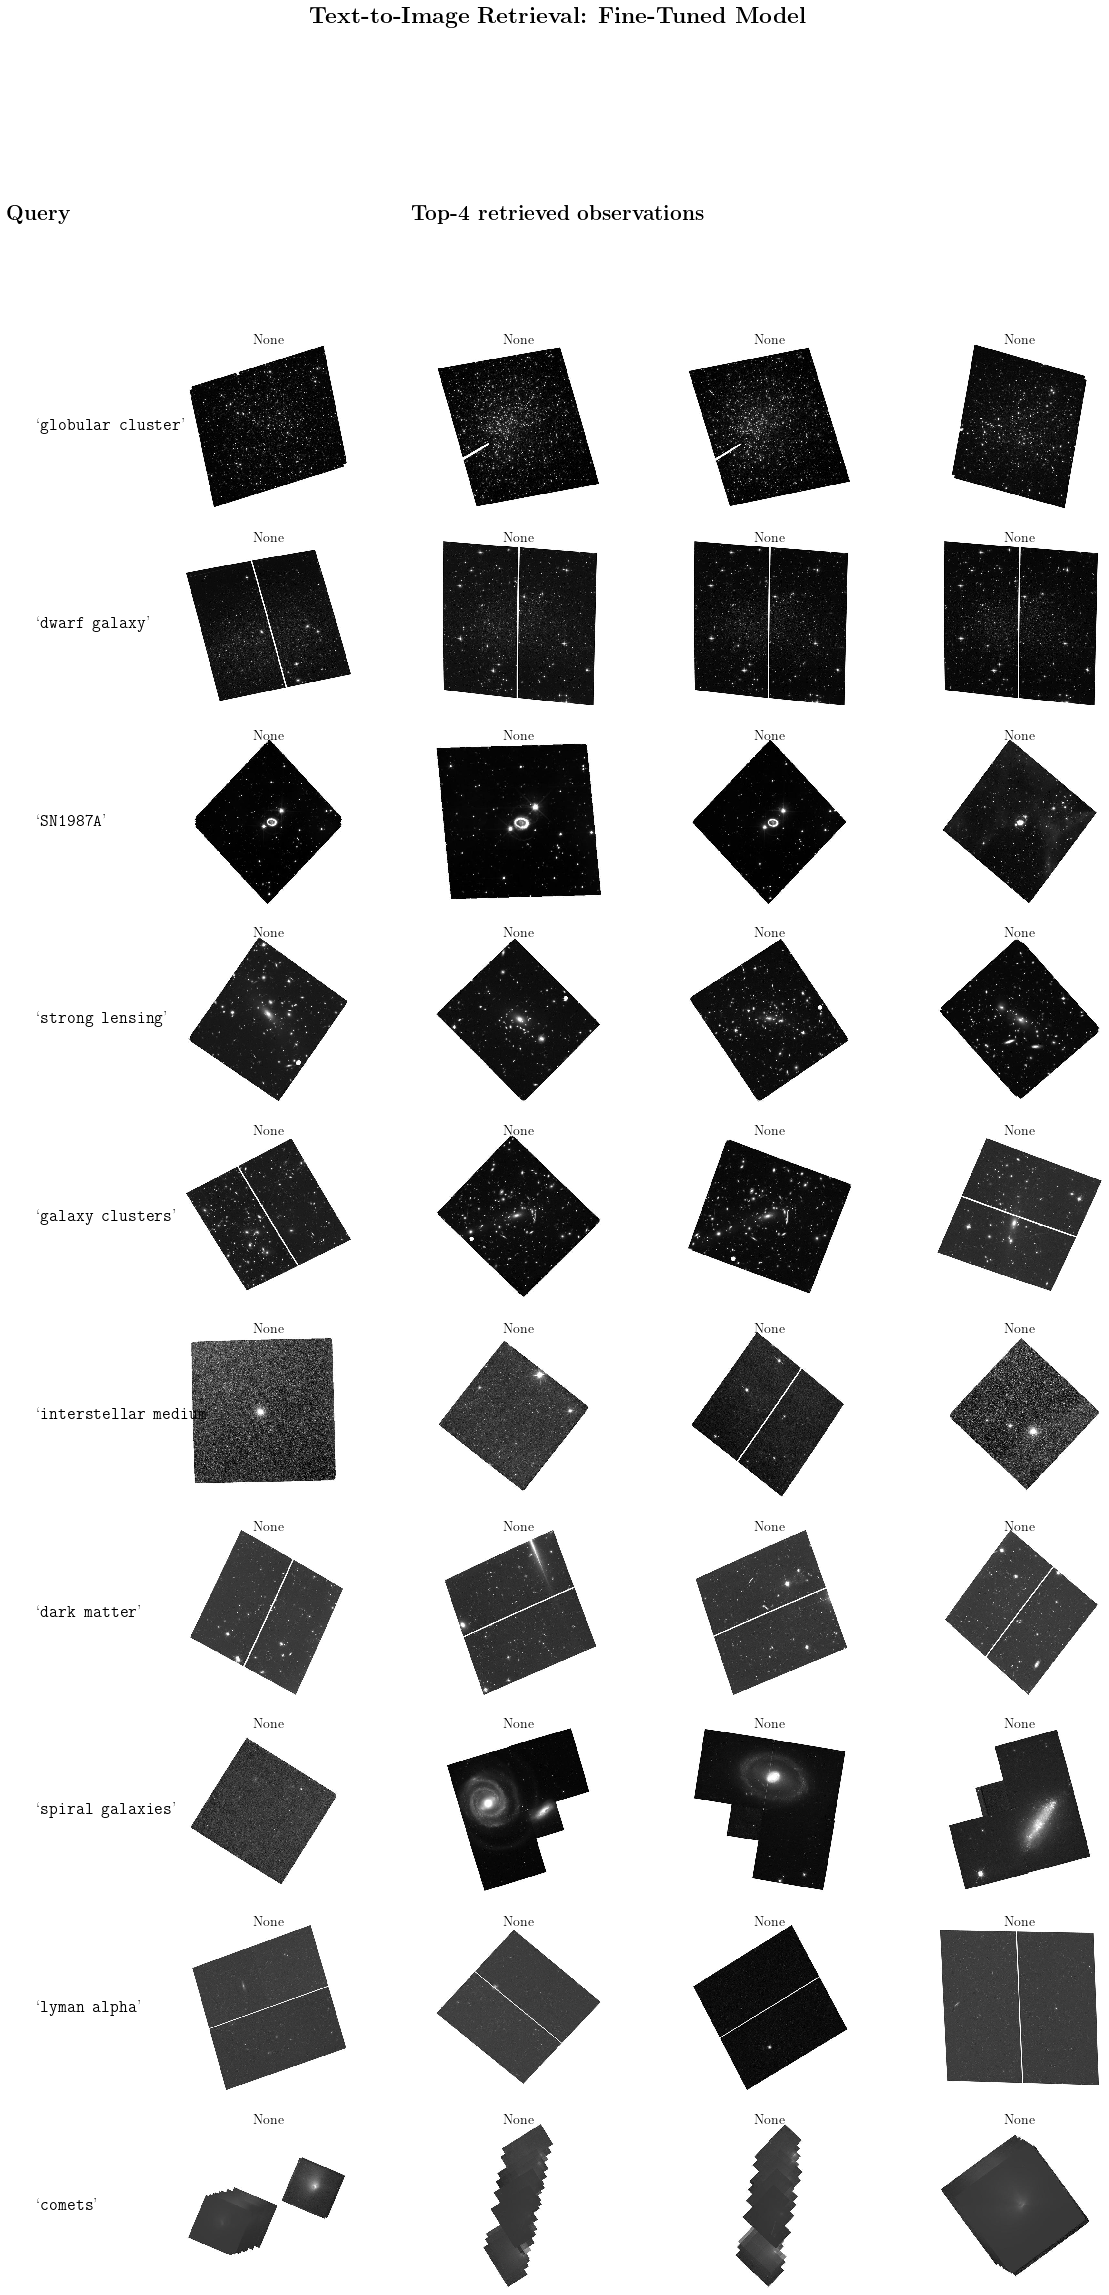

In [90]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib import rc
import matplotlib

rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{color}")
rc("text.latex", preamble=r"\usepackage{xcolor}")

# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
# queries = ["globular clusters", "dwarf galaxy", "SN1987A", "cluster lensing"] 
# List of text queries
queries = ["globular cluster", "dwarf galaxy", "SN1987A", "strong lensing", "galaxy clusters", "interstellar medium", "dark matter", "spiral galaxies", "lyman alpha", "comets"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

# Create figure with specified size
fig = plt.figure(figsize=(16, 18 * len(queries) / 5.))

# Add a main title, make "fine-tuned model" in red color font
plt.suptitle(r"\textbf{Text-to-Image Retrieval: \textcolor{red}{Fine-Tuned Model}}", fontsize=23, fontweight='bold')

axes_list = []
sorted_idxs_list = []

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=restored_state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), text_feat[0]))[::-1]

    sorted_idxs_list.append(sorted_idxs)

    # Loop through the images for this query and plot them
    for col in range(m_cols):
        idx = sorted_idxs[col]
        ax = plt.subplot(len(queries), m_cols, row * m_cols + col + 1)
        ax.imshow(get_image_from_stack(images_stack, idx))
        ax.axis('off')

        axes_list.append(ax)

        # Add text string "9999" above the image
        plt.text(0.5, 1.02, f"{get_propid_phenomena(captions_stack[idx])}", transform=ax.transAxes, fontsize=14, ha='center', va='center')

        # Add the query name to the left of the first column
        if col == 0:
            # plt.text(-0.1, 0.5, r"`\texttt{" + query + "}'", transform=ax.transAxes, fontsize=16, rotation=90, va='center', ha='right', fontfamily='monospace')
            plt.text(-0.9, 0.5, r"`\texttt{" + query + "}'", transform=ax.transAxes, fontsize=17, rotation=0, va='center', ha='left', fontfamily='monospace')    
        
# Adding labels for "Query" and "Most similar images"
# The coordinates here might need adjustment depending on your figure layout
fig.text(0.05, 0.9, r"\textbf{Query}", fontsize=21, ha='center', va='center')
fig.text(0.5, 0.9, r"\textbf{Top-4 retrieved observations}", fontsize=21, ha='center', va='center')

plt.subplots_adjust(left=0.15, right=1, top=0.85, bottom=0.1, wspace=0.1, hspace=0.2)

# plt.tight_layout()
# plt.savefig("../paper/plots/tti.pdf", dpi=500)
# plt.savefig("../paper/plots/tti_abs.pdf", dpi=500)

In [91]:
# Open the file in write mode

for idx_q in range(10):
    with open(f'eval_quant/captions_ft_{idx_q}.txt', 'w') as file:
        # Loop over each array in sorted_idxs_list
        selected_captions = [captions_stack[idx] for idx in sorted_idxs_list[idx_q][:10]]
        
        # Write the captions to the file
        for caption in selected_captions:
            file.write(caption + '\n')

In [78]:
with open(f'eval_quant/queries.txt', 'w') as file:
    # Write the captions to the file
    for caption in queries:
        file.write(caption + '\n')

In [77]:
# [captions_stack[idx] for idx in sorted_idxs_list[-1]][:10]

## Base model

In [47]:
batches = iter(ds)

In [48]:
import jax

image_base_feat_stack = []
images_base_stack = []
captions_base_stack = []

for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_base_stack += captions

    images_base_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=state.params);
    image_base_feat_stack.append(image_feat)

100%|██████████████████████████████████████████████████████████████████████| 100/100 [03:52<00:00,  2.32s/it]


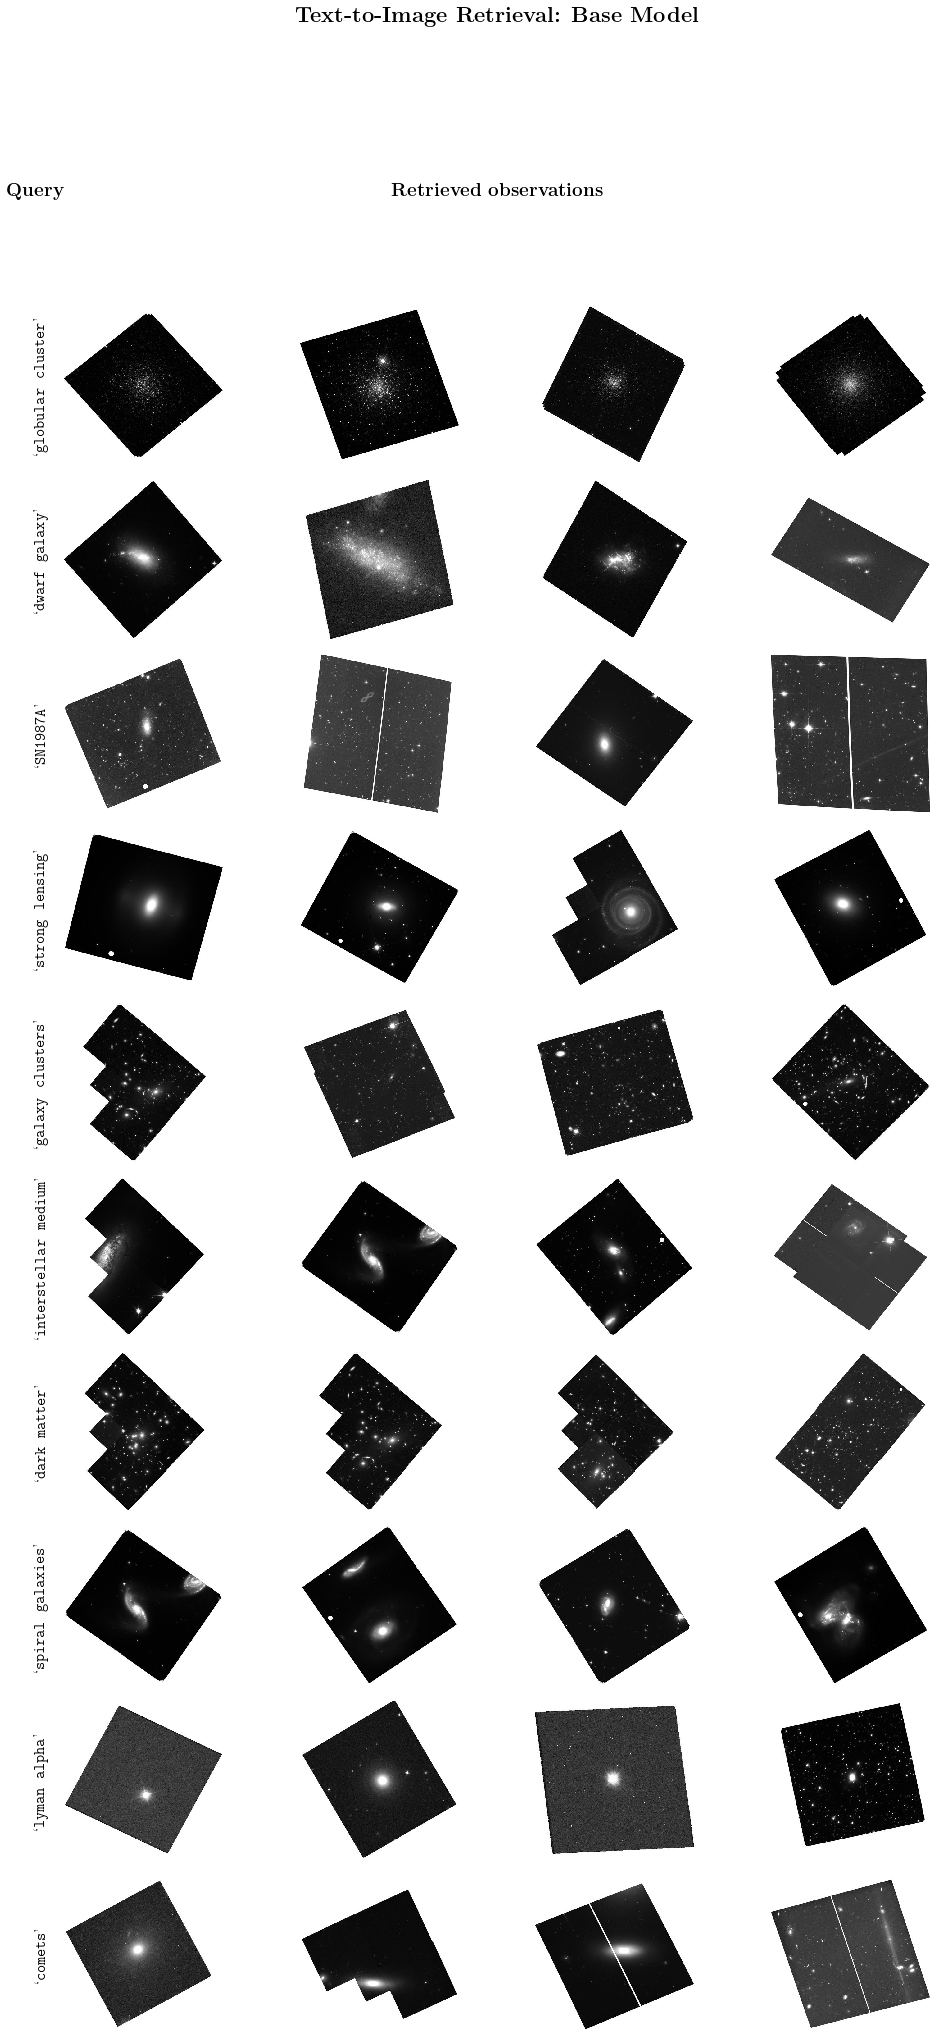

In [88]:
# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
queries = ["globular cluster", "dwarf galaxy", "SN1987A", "strong lensing", "galaxy clusters", "interstellar medium", "dark matter", "spiral galaxies", "lyman alpha", "comets"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

# Create figure with specified size
fig = plt.figure(figsize=(16, 16 * len(queries) / 5.))

# Add a main title
plt.suptitle(r"\textbf{Text-to-Image Retrieval: Base Model}", fontsize=22, fontweight='bold')

axes_list = []
sorted_idxs_list = []

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_base_feat_stack), text_feat[0]))[::-1]
    sorted_idxs_list.append(sorted_idxs)

    # Loop through the images for this query and plot them
    for col in range(m_cols):
        idx = sorted_idxs[col]
        ax = plt.subplot(len(queries), m_cols, row * m_cols + col + 1)
        ax.imshow(get_image_from_stack(images_base_stack, idx))
        ax.axis('off')

        axes_list.append(ax)

        # Add the query name to the left of the first column
        if col == 0:
            plt.text(-0.1, 0.5, r"`\texttt{" + query + "}'", transform=ax.transAxes, fontsize=16, rotation=90, va='center', ha='right', fontfamily='monospace')

# Adding labels for "Query" and "Most similar images"
# The coordinates here might need adjustment depending on your figure layout
fig.text(0.1, 0.9, r"\textbf{Query}", fontsize=19, ha='center', va='center')
fig.text(0.5, 0.9, r"\textbf{Retrieved observations}", fontsize=19, ha='center', va='center')

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1, wspace=0.1, hspace=0.1)
# plt.savefig("../paper/plots/tti_base.pdf", dpi=500)

In [89]:
# Open the file in write mode

for idx_q in range(10):
    with open(f'eval_quant/captions_base_{idx_q}.txt', 'w') as file:
        # Extract the first 10 captions for the current array
        selected_captions = [captions_base_stack[idx] for idx in sorted_idxs_list[idx_q][:10]]
        
        # Write the captions to the file
        for caption in selected_captions:
            file.write(caption + '\n')

In [80]:
# [captions_base_stack[idx] for idx in sorted_idxs_list[-1]][:10]

In [85]:
len(selected_captions)

10

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

for idx_q, query in tqdm(enumerate(queries)):
        
    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    
    # Fit and transform the captions
    tfidf_matrix = vectorizer.fit_transform(captions_stack)
    
    # Transform the query using the same vectorizer
    query_tfidf = vectorizer.transform([query])
    
    # Compute cosine similarities between the query and all captions
    cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
    
    # Get the indices of the top 10 captions
    top_10_indices = np.argsort(cosine_similarities)[-10:][::-1]
    
    # Get the top 10 captions
    top_10_captions = [captions_stack[idx] for idx in top_10_indices]
    
    # Save 
    # Open the file in write mode
    
    with open(f'eval_quant/captions_tfid_{idx_q}.txt', 'w') as file:
        # Extract the first 10 captions for the current array
        selected_captions = [cap for cap in top_10_captions]
        
        # Write the captions to the file
        for caption in selected_captions:
            file.write(caption + '\n')

10it [00:02,  3.65it/s]
